In [5]:
#Imports
import pandas as pd
import numpy as np
import os
import glob
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
import statsmodels.api as sm
import matplotlib.pyplot as plt



First, we will analyze all of the data in the Disruptions folder. This will be done in the codeblocks below using the sklearn module and statsmodels module.



In [14]:
disruptions_folder = 'C:/Users/frank/Downloads/TIL Programming/Disruptions'

def process_data(folder):
    csv_files = glob.glob(os.path.join(disruptions_folder, "disruptions-*.csv"))
    if not csv_files:
        print(f"No CSV in '{disruptions_folder}'.")
        return None

    df_list = [pd.read_csv(file) for file in csv_files]
    disruptions_df = pd.concat(df_list, ignore_index=True)
    disruptions_df['start_time'] = pd.to_datetime(disruptions_df['start_time'])
    disruptions_df['end_time'] = pd.to_datetime(disruptions_df['end_time'])
    
    Q1 = disruptions_df['duration_minutes'].quantile(0.25)
    Q3 = disruptions_df['duration_minutes'].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR    
    outliers = disruptions_df[disruptions_df['duration_minutes'] > upper_bound] 
    
    df = disruptions_df[disruptions_df['duration_minutes'] <= upper_bound].copy()
    return df

total_disruption_df = process_data(disruptions_folder)
if total_disruption_df is not None:
    df_indexed = total_disruption_df.set_index('start_time')
    df_per_hour = df_indexed.resample('h').size().to_frame('disruption_count')
    #print(df_per_hour)
    df_per_hour['hour'] = df_per_hour.index.hour
    df_per_hour['day'] = df_per_hour.index.dayofweek
    df_per_hour['month'] = df_per_hour.index.month
    #df_per_hour['year'] = df_per_hour.index.year 
    #print(df_per_hour)
    is_weekday = df_per_hour['day'] < 5
    is_morning_peak = (df_per_hour['hour'] >= 6) & (df_per_hour['hour'] < 9)
    is_evening_peak = (df_per_hour['hour'] >= 16) & (df_per_hour['hour'] < 19)
    df_per_hour['is_peak'] = (is_weekday & (is_morning_peak | is_evening_peak))    
    #print(df_per_hour)
    #Create lagged feature, https://scikit-learn.org/stable/auto_examples/applications/plot_time_series_lagged_features.html    
    df_per_hour['lag_1h'] = df_per_hour['disruption_count'].shift(1)
    df_per_hour['lag_24h'] = df_per_hour['disruption_count'].shift(24)
    df_per_hour['lag_1_week'] = df_per_hour['disruption_count'].shift(24 * 7)
    df_per_hour['avg_disruptions_24h'] = df_per_hour['disruption_count'].shift(1).rolling(window=24).mean()
    df_per_hour = df_per_hour.dropna()
    print(df_per_hour.head())  
    target = 'disruption_count'
    feature_columns = [column for column in df_per_hour.columns if column != target]
    
    X = df_per_hour[feature_columns]
    Y = df_per_hour[target]    

    test_percentage = 0.2
    split = int(len(df_per_hour) * (1-test_percentage))

    X_train = X.iloc[:split]
    Y_train = (Y.iloc[:split] > 0).astype(int)
    X_test = X.iloc[split:]
    Y_test = (Y.iloc[split:] > 0).astype(int)

    print(Y_train.value_counts())

    random_forest_model = RandomForestClassifier(n_estimators=100, random_state = 42, n_jobs = -1, class_weight = 'balanced')    
    random_forest_model.fit(X_train, Y_train)
    predict = random_forest_model.predict(X_test)
    accuracy = accuracy_score(Y_test, predict)
    print(f"Accuracy = {accuracy}")
    print(classification_report(Y_test, predict, target_names=['No Disruption (0)', 'Disruption (1)']))
    
    #print(f"RMSE of the random forest regressor is: {RMSE}")
    #print(Y_test.describe())

    #print(f"X_train = {X_train.head(10)}\n\nY_train = {Y_train.head(10)}")

                     disruption_count  hour  day  month  is_peak  lag_1h  \
start_time                                                                 
2011-01-10 23:00:00                 0    23    0      1    False     0.0   
2011-01-11 00:00:00                 0     0    1      1    False     0.0   
2011-01-11 01:00:00                 0     1    1      1    False     0.0   
2011-01-11 02:00:00                 0     2    1      1    False     0.0   
2011-01-11 03:00:00                 0     3    1      1    False     0.0   

                     lag_24h  lag_1_week  avg_disruptions_24h  
start_time                                                     
2011-01-10 23:00:00      0.0         1.0             0.208333  
2011-01-11 00:00:00      0.0         1.0             0.208333  
2011-01-11 01:00:00      0.0         0.0             0.208333  
2011-01-11 02:00:00      0.0         0.0             0.208333  
2011-01-11 03:00:00      0.0         0.0             0.208333  
disruption_count
0 

In [15]:
disruptions_folder = 'C:/Users/frank/Downloads/TIL Programming/Disruptions'

def process_data(folder):
    csv_files = glob.glob(os.path.join(disruptions_folder, "disruptions-*.csv"))
    if not csv_files:
        print(f"No CSV in '{disruptions_folder}'.")
        return None

    df_list = [pd.read_csv(file) for file in csv_files]
    disruptions_df = pd.concat(df_list, ignore_index=True)
    disruptions_df['start_time'] = pd.to_datetime(disruptions_df['start_time'])
    disruptions_df['end_time'] = pd.to_datetime(disruptions_df['end_time'])
    
    Q1 = disruptions_df['duration_minutes'].quantile(0.25)
    Q3 = disruptions_df['duration_minutes'].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR    
    outliers = disruptions_df[disruptions_df['duration_minutes'] > upper_bound] 
    
    df = disruptions_df[disruptions_df['duration_minutes'] <= upper_bound].copy()
    return df

total_disruption_df = process_data(disruptions_folder)
if total_disruption_df is not None:
    df_indexed = total_disruption_df.set_index('start_time')
    df_per_hour = df_indexed.resample('h').size().to_frame('disruption_count')
    #print(df_per_hour)
    df_per_hour['hour'] = df_per_hour.index.hour
    df_per_hour['day'] = df_per_hour.index.dayofweek
    df_per_hour['month'] = df_per_hour.index.month
    #df_per_hour['year'] = df_per_hour.index.year 
    #print(df_per_hour)
    is_weekday = df_per_hour['day'] < 5
    is_morning_peak = (df_per_hour['hour'] >= 6) & (df_per_hour['hour'] < 9)
    is_evening_peak = (df_per_hour['hour'] >= 16) & (df_per_hour['hour'] < 19)
    df_per_hour['is_peak'] = (is_weekday & (is_morning_peak | is_evening_peak))    
    #print(df_per_hour)
    #Create lagged feature, https://scikit-learn.org/stable/auto_examples/applications/plot_time_series_lagged_features.html    
    df_per_hour['lag_1h'] = df_per_hour['disruption_count'].shift(1)
    df_per_hour['lag_24h'] = df_per_hour['disruption_count'].shift(24)
    df_per_hour['lag_1_week'] = df_per_hour['disruption_count'].shift(24 * 7)
    df_per_hour['avg_disruptions_24h'] = df_per_hour['disruption_count'].shift(1).rolling(window=24).mean()
    df_per_hour = df_per_hour.dropna()
    print(df_per_hour.head())  
    target = 'disruption_count'
    feature_columns = [column for column in df_per_hour.columns if column != target]
    X = df_per_hour[feature_columns]
    Y = df_per_hour[target]    

    test_percentage = 0.2
    split = int(len(df_per_hour) * (1-test_percentage))

    X_train = X.iloc[:split].astype(float)
    Y_train = Y.iloc[:split]
    X_test = X.iloc[split:].astype(float)
    Y_test = Y.iloc[split:]    

    X_train_const = sm.add_constant(X_train, prepend=False)
    X_test_const = sm.add_constant(X_test, prepend=False)

    model = sm.ZeroInflatedNegativeBinomialP(endog=Y_train, exog=X_train_const)
    results = model.fit(method='bfgs', maxiter=500, disp=False)
    predict = np.round(results.predict(X_test_const)).astype(int)

    RMSE = np.sqrt(mean_squared_error(Y_test, predict))
    print(f"RMSE is: {RMSE}")

    predict_binary = (predict > 0).astype(int)
    Y_test_binary = (Y_test > 0).astype(int)
    print(classification_report(Y_test_binary, predict_binary, target_names=['No Disruption (0)', 'Disruption (1)']))

                     disruption_count  hour  day  month  is_peak  lag_1h  \
start_time                                                                 
2011-01-10 23:00:00                 0    23    0      1    False     0.0   
2011-01-11 00:00:00                 0     0    1      1    False     0.0   
2011-01-11 01:00:00                 0     1    1      1    False     0.0   
2011-01-11 02:00:00                 0     2    1      1    False     0.0   
2011-01-11 03:00:00                 0     3    1      1    False     0.0   

                     lag_24h  lag_1_week  avg_disruptions_24h  
start_time                                                     
2011-01-10 23:00:00      0.0         1.0             0.208333  
2011-01-11 00:00:00      0.0         1.0             0.208333  
2011-01-11 01:00:00      0.0         0.0             0.208333  
2011-01-11 02:00:00      0.0         0.0             0.208333  
2011-01-11 03:00:00      0.0         0.0             0.208333  
RMSE is: 3.41837602

                     disruption_count  hour  day  month  year  is_peak  \
start_time                                                               
2011-01-10 23:00:00                 0    23    0      1  2011    False   
2011-01-11 00:00:00                 0     0    1      1  2011    False   
2011-01-11 01:00:00                 0     1    1      1  2011    False   
2011-01-11 02:00:00                 0     2    1      1  2011    False   
2011-01-11 03:00:00                 0     3    1      1  2011    False   

                     lag_1h  lag_24h  lag_1_week  avg_disruptions_24h  
start_time                                                             
2011-01-10 23:00:00     0.0      0.0         1.0             0.208333  
2011-01-11 00:00:00     0.0      0.0         1.0             0.208333  
2011-01-11 01:00:00     0.0      0.0         0.0             0.208333  
2011-01-11 02:00:00     0.0      0.0         0.0             0.208333  
2011-01-11 03:00:00     0.0      0.0         0.0 

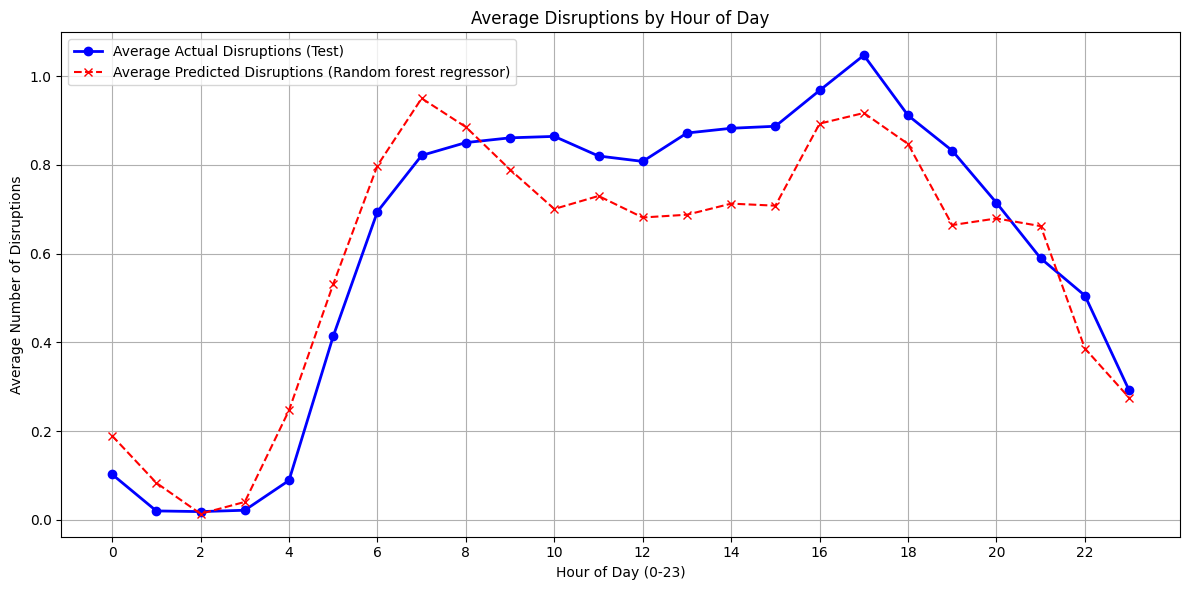

In [13]:
disruptions_folder = 'C:/Users/frank/Downloads/TIL Programming/Disruptions'

def process_data(folder):
    csv_files = glob.glob(os.path.join(disruptions_folder, "disruptions-*.csv"))
    if not csv_files:
        print(f"No CSV in '{disruptions_folder}'.")
        return None

    df_list = [pd.read_csv(file) for file in csv_files]
    disruptions_df = pd.concat(df_list, ignore_index=True)
    disruptions_df['start_time'] = pd.to_datetime(disruptions_df['start_time'])
    disruptions_df['end_time'] = pd.to_datetime(disruptions_df['end_time'])
    
    Q1 = disruptions_df['duration_minutes'].quantile(0.25)
    Q3 = disruptions_df['duration_minutes'].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR    
    outliers = disruptions_df[disruptions_df['duration_minutes'] > upper_bound] 
    
    df = disruptions_df[disruptions_df['duration_minutes'] <= upper_bound].copy()
    return df

total_disruption_df = process_data(disruptions_folder)
if total_disruption_df is not None:
    df_indexed = total_disruption_df.set_index('start_time')
    df_per_hour = df_indexed.resample('h').size().to_frame('disruption_count')
    #print(df_per_hour)
    df_per_hour['hour'] = df_per_hour.index.hour
    df_per_hour['day'] = df_per_hour.index.dayofweek
    df_per_hour['month'] = df_per_hour.index.month
    df_per_hour['year'] = df_per_hour.index.year 
    #print(df_per_hour)
    is_weekday = df_per_hour['day'] < 5
    is_morning_peak = (df_per_hour['hour'] >= 6) & (df_per_hour['hour'] < 9)
    is_evening_peak = (df_per_hour['hour'] >= 16) & (df_per_hour['hour'] < 19)
    df_per_hour['is_peak'] = (is_weekday & (is_morning_peak | is_evening_peak))    
    #print(df_per_hour)
    #Create lagged feature, https://scikit-learn.org/stable/auto_examples/applications/plot_time_series_lagged_features.html    
    df_per_hour['lag_1h'] = df_per_hour['disruption_count'].shift(1)
    df_per_hour['lag_24h'] = df_per_hour['disruption_count'].shift(24)
    df_per_hour['lag_1_week'] = df_per_hour['disruption_count'].shift(24 * 7)
    df_per_hour['avg_disruptions_24h'] = df_per_hour['disruption_count'].shift(1).rolling(window=24).mean()
    df_per_hour = df_per_hour.dropna()
    print(df_per_hour.head())  
    target = 'disruption_count'
    feature_columns = [column for column in df_per_hour.columns if column != target]
    
    X = df_per_hour[feature_columns]
    Y = df_per_hour[target]    

    test_percentage = 0.2
    split = int(len(df_per_hour) * (1-test_percentage))

    X_train = X.iloc[:split]
    Y_train = Y.iloc[:split]
    X_test = X.iloc[split:]
    Y_test = Y.iloc[split:]
    Y_test_binary = (Y_test > 0).astype(int)

    random_forest_model = RandomForestRegressor(n_estimators=100, random_state = 42, n_jobs = -1)
    random_forest_model.fit(X_train, Y_train)
    predict = random_forest_model.predict(X_test)
    RMSE = np.sqrt(mean_squared_error(Y_test, predict))
    print(f"RMSE is: {RMSE}")
    #print(Y_test.describe())
    predict_binary = (np.round(predict) > 0).astype(int)
    accuracy = accuracy_score(Y_test_binary, predict_binary)
    #print(f"Accuracy: {accuracy}")
    print(classification_report(Y_test_binary, predict_binary, target_names=['No Disruption (0)', 'Disruption (1)']))
    
    #print(f"RMSE of the random forest regressor is: {RMSE}")
    #print(Y_test.describe())

    #print(f"X_train = {X_train.head(10)}\n\nY_train = {Y_train.head(10)}")

    df_plot = pd.DataFrame({'hour': X_test['hour'],'Actual': Y_test,'Predicted': predict}).groupby('hour').mean()

    plt.figure(figsize=(12, 6))
    plt.plot(df_plot.index, df_plot['Actual'], label='Average Actual Disruptions (Test)', color='blue', marker='o', linewidth=2)
    plt.plot(df_plot.index, df_plot['Predicted'], label='Average Predicted Disruptions (Random forest regressor)', color='red', marker='x', linestyle='--')
    
    plt.title('Average Disruptions by Hour of Day')
    plt.xlabel('Hour of Day (0-23)')
    plt.ylabel('Average Number of Disruptions')
    plt.xticks(range(0, 24, 2))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("disruption_plot_final_predicted")
    plt.show()    